# Model Loading and Predicting
by Prince Joseph Erneszer Javier

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.metrics import average_precision_score

from scipy.stats import kurtosis, skew
from collections import Counter

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout

seed = 42
np.random.seed(seed)

import ast

# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Loading Data

In [2]:
# paths of features and labels
path_feats ="data/processed/df_test.csv"
path_labels = "data/safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv"

df_feats = pd.read_csv(path_feats)
df_labels = pd.read_csv(path_labels).drop_duplicates()

In [3]:
df_feats.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,124,3.291,235.0,0.644974,8.789276,1.732346,-0.037781,-0.046967,-0.021515,0.0,1.03
1,124,3.215,235.0,0.772400,9.392273,1.929749,0.015366,0.005249,0.023987,1.0,1.36
2,124,3.179,233.0,0.864517,9.772736,1.314194,0.014740,0.028168,0.082626,2.0,1.95
3,124,3.656,231.0,0.679672,8.870636,2.176208,0.001312,-0.012146,0.026428,3.0,3.23
4,124,3.905,231.0,0.381775,9.333649,1.790970,0.015671,0.013809,0.008408,4.0,3.83


In [4]:
df_labels.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


## Data Preprocessing

### Feature Engineering

In [5]:
# we engineer feature, aggregating feature values per bookingID
# getting min, max, range, mean, std, skewness, and kurtosis

df_engg_feats = df_feats.drop("second", axis=1)
df_engg_feats = df_engg_feats.groupby(by="bookingID", as_index=True).agg([np.min, np.max, np.ptp, np.mean, np.std, skew, kurtosis])
df_engg_feats.head()


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Accuracy                                                  \
               amin    amax     ptp       mean       std       skew   
bookingID                                                             
124             3.0  15.008  12.008   7.147938  2.486692   0.139104   
162             3.0  10.937   7.937   3.785293  0.476145   5.624208   
8589934624     10.0  32.000  22.000  10.433486  2.711012   6.648893   
8589934648      3.0  14.783  11.783   3.708070  0.524037   7.543774   
8589934652      3.0  32.000  29.000   3.958367  1.511782  12.225604   

                         Bearing                          ...    gyro_z  \
              kurtosis      amin        amax         ptp  ...       std   
bookingID                                                 ...             
124          -0.818033  0.000000  358.000000  358.000000  ...  0.058255   
162          79.958988  0.000000  359.000000  359.000000  ...  0.030205   
8589934624   43.923071  0.258441  353.979034  353.720593  ...  0.042796   
8589934648  152.981841  0.000000  263.000000  263.000000  ...  0.028181   
8589934652  193.562775  0.000000  359.000000  359.000000  ...  0.064522   

                                Speed                                   \
                skew   kurtosis  amin       amax        ptp       mean   
bookingID                                                                
124         0.224779  40.600775   0.0  13.920000  13.920000   4.553212   
162        -0.798692   5.312550  -1.0  27.980000  28.980000  14.892732   
8589934624 -0.715125  30.589820  -1.0  21.049999  22.049999   4.872339   
8589934648 -0.236509   6.117009   0.0  24.020000  24.020000  10.398451   
8589934652 -0.163468   1.212642  -1.0  27.426030  28.426030  14.777113   

                                          
                 std      skew  kurtosis  
bookingID                                 
124         4.370550  0.438431 -1.173504  
162         8.908004 -0.412321 -1.120888  
8589934624  5.933472  1.396884  0.578838  
8589934648  7.463056 -0.108021 -1.333071  
8589934652  9.330526 -0.507820 -1.344912  

[5 rows x 63 columns]

In [6]:
# flatten column names
cols = [df_engg_feats.columns[i][0]+"_"+df_engg_feats.columns[i][1] for i in range(len(df_engg_feats.columns))]

In [7]:
df_engg_feats.columns = cols
df_engg_feats.reset_index(inplace=True)
df_engg_feats.head()

,bookingID,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Bearing_amin,Bearing_amax,...,gyro_z_std,gyro_z_skew,gyro_z_kurtosis,Speed_amin,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis
0,124,3.0,15.008,12.008,7.147938,2.486692,0.139104,-0.818033,0.000000,358.000000,...,0.058255,0.224779,40.600775,0.0,13.920000,13.920000,4.553212,4.370550,0.438431,-1.173504
1,162,3.0,10.937,7.937,3.785293,0.476145,5.624208,79.958988,0.000000,359.000000,...,0.030205,-0.798692,5.312550,-1.0,27.980000,28.980000,14.892732,8.908004,-0.412321,-1.120888
2,8589934624,10.0,32.000,22.000,10.433486,2.711012,6.648893,43.923071,0.258441,353.979034,...,0.042796,-0.715125,30.589820,-1.0,21.049999,22.049999,4.872339,5.933472,1.396884,0.578838
3,8589934648,3.0,14.783,11.783,3.708070,0.524037,7.543774,152.981841,0.000000,263.000000,...,0.028181,-0.236509,6.117009,0.0,24.020000,24.020000,10.398451,7.463056,-0.108021,-1.333071
4,8589934652,3.0,32.000,29.000,3.958367,1.511782,12.225604,193.562775,0.000000,359.000000,...,0.064522,-0.163468,1.212642,-1.0,27.426030,28.426030,14.777113,9.330526,-0.507820,-1.344912


In [8]:
df_engg_feats.shape

(1000, 64)

In [9]:
# add length of each trip
df_len = df_feats.groupby(by="bookingID", as_index=True).agg(len).iloc[:, 0:1]
df_len.columns = ['trip_len']
df_len.reset_index(inplace=True)
df_len.head()

,bookingID,trip_len
0,124,660.0
1,162,765.0
2,8589934624,436.0
3,8589934648,1595.0
4,8589934652,1645.0


In [10]:
# merge along bookingID
df_engg_feats_2 = pd.merge(df_engg_feats, df_len, how="inner", on="bookingID")
df_engg_feats_2.head()

,bookingID,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Bearing_amin,Bearing_amax,...,gyro_z_skew,gyro_z_kurtosis,Speed_amin,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,trip_len
0,124,3.0,15.008,12.008,7.147938,2.486692,0.139104,-0.818033,0.000000,358.000000,...,0.224779,40.600775,0.0,13.920000,13.920000,4.553212,4.370550,0.438431,-1.173504,660.0
1,162,3.0,10.937,7.937,3.785293,0.476145,5.624208,79.958988,0.000000,359.000000,...,-0.798692,5.312550,-1.0,27.980000,28.980000,14.892732,8.908004,-0.412321,-1.120888,765.0
2,8589934624,10.0,32.000,22.000,10.433486,2.711012,6.648893,43.923071,0.258441,353.979034,...,-0.715125,30.589820,-1.0,21.049999,22.049999,4.872339,5.933472,1.396884,0.578838,436.0
3,8589934648,3.0,14.783,11.783,3.708070,0.524037,7.543774,152.981841,0.000000,263.000000,...,-0.236509,6.117009,0.0,24.020000,24.020000,10.398451,7.463056,-0.108021,-1.333071,1595.0
4,8589934652,3.0,32.000,29.000,3.958367,1.511782,12.225604,193.562775,0.000000,359.000000,...,-0.163468,1.212642,-1.0,27.426030,28.426030,14.777113,9.330526,-0.507820,-1.344912,1645.0


In [11]:
# left join with labels (aggregating and feature engineering)
df_engg_feats_labels = pd.merge(df_engg_feats_2, df_labels, how="inner", on="bookingID")
df_engg_feats_labels.head()

,bookingID,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Bearing_amin,Bearing_amax,...,gyro_z_kurtosis,Speed_amin,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,trip_len,label
0,124,3.0,15.008,12.008,7.147938,2.486692,0.139104,-0.818033,0.000000,358.000000,...,40.600775,0.0,13.920000,13.920000,4.553212,4.370550,0.438431,-1.173504,660.0,0
1,162,3.0,10.937,7.937,3.785293,0.476145,5.624208,79.958988,0.000000,359.000000,...,5.312550,-1.0,27.980000,28.980000,14.892732,8.908004,-0.412321,-1.120888,765.0,0
2,8589934624,10.0,32.000,22.000,10.433486,2.711012,6.648893,43.923071,0.258441,353.979034,...,30.589820,-1.0,21.049999,22.049999,4.872339,5.933472,1.396884,0.578838,436.0,0
3,8589934648,3.0,14.783,11.783,3.708070,0.524037,7.543774,152.981841,0.000000,263.000000,...,6.117009,0.0,24.020000,24.020000,10.398451,7.463056,-0.108021,-1.333071,1595.0,0
4,8589934652,3.0,32.000,29.000,3.958367,1.511782,12.225604,193.562775,0.000000,359.000000,...,1.212642,-1.0,27.426030,28.426030,14.777113,9.330526,-0.507820,-1.344912,1645.0,0


In [12]:
df_engg_feats_labels.drop_duplicates(subset="bookingID", inplace=True)
df_engg_feats_labels.shape

(1000, 66)

### Scaling

In [13]:
# load scaler
path = "scalers/minmax.sav"
sc = pickle.load(open(path, 'rb'))
sc

MinMaxScaler(copy=True, feature_range=(0, 1))

In [62]:
X = df_engg_feats_2.drop(["bookingID"], axis=1)
cols = X.columns

# scale X
X = pd.DataFrame(sc.transform(X))
X.columns = cols

# drop duplicates
X.drop_duplicates(inplace=True)

# Selecting certain features
results = pd.read_csv("results/ml_results_b_minmax.csv")
cols = ast.literal_eval(results[results.model=="gbm_b"].features.values[0])

# selected features
X = X[cols]

print(X.shape)
X.head()

(1000, 16)


,trip_len,acceleration_z_std,Speed_skew,Speed_mean,Bearing_std,Speed_ptp,gyro_y_amax,gyro_y_ptp,Accuracy_mean,gyro_z_std,gyro_x_kurtosis,gyro_z_kurtosis,gyro_y_kurtosis,acceleration_y_mean,acceleration_y_amin,acceleration_z_amin
0,0.072571,0.080774,0.417809,0.202352,0.770121,0.093411,0.006475,0.011313,0.003466,0.016200,0.008483,0.026978,0.006935,0.382974,0.775730,0.841912
1,0.086682,0.059212,0.370249,0.579112,0.892885,0.194472,0.002856,0.005980,0.001252,0.008326,0.002186,0.004229,0.002231,0.373380,0.757667,0.921196
2,0.042467,0.073645,0.471389,0.213981,0.506861,0.147968,0.010524,0.015899,0.005629,0.011860,0.003738,0.020524,0.004058,0.009170,0.581389,0.860860
3,0.198226,0.068646,0.387260,0.415346,0.435076,0.161188,0.005547,0.008047,0.001201,0.007758,0.004084,0.004747,0.011378,0.393650,0.771747,0.821312
4,0.204946,0.122472,0.364910,0.574899,0.555473,0.190755,0.006966,0.012464,0.001366,0.017959,0.002555,0.001585,0.003193,0.403585,0.764616,0.819422


In [63]:
y = df_engg_feats_labels.label
print(y.shape)
y.head()

(1000,)


0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [64]:
# 0s and 1s
Counter(y)

Counter({0: 736, 1: 264})

## Model Predicting

In [69]:
# # load the model from disk (machine learning)
# filename = "models/svc_b_minmax.sav"
# model = pickle.load(open(filename, 'rb'))
# result = model.score(X, y)
# y_pred = model.predict(X)
# print(result)
# print(accuracy_score(y, y_pred))

# Deep learning
filename = "models/mlp_minmax_relu_adam_dropout-0.05_cols-16.hdf5"
model = load_model(filename)
y_pred = np.round(model.predict(X))
print(accuracy_score(y, y_pred))


0.703


Confusion matrix, without normalization
[[576 160]
 [137 127]]
Normalized confusion matrix
[[0.78 0.22]
 [0.52 0.48]]


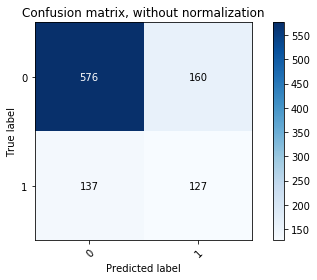

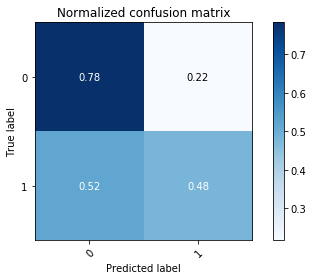

In [70]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0, 1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names = [0, 1]

# Plot non-normalized confusion matrix
plot_confusion_matrix(y, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [67]:
# Precision, Recall
y_score = model.decision_function(X)
average_precision = average_precision_score(y, y_score)

print('Average precision score: {0:0.2f}'.format(
      average_precision))

AttributeError: 'Sequential' object has no attribute 'decision_function'

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.51')

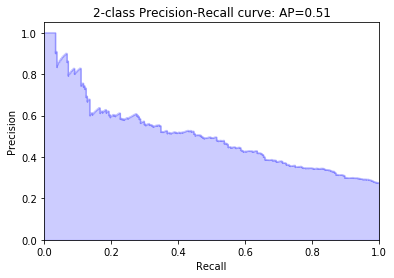

In [68]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [36]:
# # ROC Curve
# # How to interpret this?
# roc_curve(y, y_pred)